In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
import time 
import sys
import pandas as pd
import numpy as np
import torchvision.utils
import torchvision.datasets as Datasets

In [5]:
mnist_train = Datasets.FashionMNIST(root='./Datasets/FashionMNIST',train=True,download=True,transform=transforms.ToTensor())
mnist_test = Datasets.FashionMNIST(root='./Datasets/FashionMNIST',train=True,download=True,transform=transforms.ToTensor())

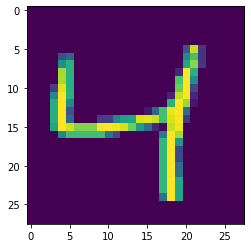

In [6]:
m_train = Datasets.MNIST(root='./Datasets/MINIST',train=True,download=True,transform=transforms.ToTensor())
m_test = Datasets.MNIST(root='./Datasets/MINIST',train=False,download=True,transform=transforms.ToTensor())
img = m_train[2][0].numpy().reshape(28,28)
plt.imshow(img)

In [7]:
# 本函数已保存在d2lzh包中方便以后使用
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


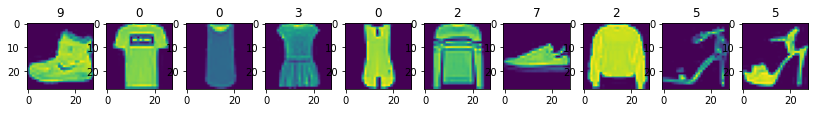

In [8]:
def show_fashion_mnist(images,labels):
  figs,ax = plt.subplots(nrows=1,ncols=len(images),figsize=(14,14))
  for f,img,lbl in zip(ax,images,labels):
    f.imshow(img.reshape(28,28).numpy())
    f.set_title(lbl)
  plt.show()

images = [mnist_train[i][0] for i in range(10)]
labels = [mnist_train[i][1] for i in range(10)]
show_fashion_mnist(images,labels)

In [9]:
batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False)
start = time.time()
for X,y in train_iter:
  continue
print('%.2f sec' % (time.time() - start))

4.11 sec


# SoftMax的回归从零开始

In [10]:
num_inputs = 28*28
num_outputs = 10
W = torch.tensor(np.random.normal(0,0.01,(num_inputs,num_outputs)),dtype=torch.float32,requires_grad=True)
b = torch.zeros(num_outputs,dtype=torch.float32,requires_grad=True)

def softmax(X):#这里的X是一个batch算出来的矩阵n*c n为一个batch的数量c为类别数量
  X_exp = X.exp()#取指数函数
  partition = X_exp.sum(dim=1,keepdim=True)
  return X_exp/partition# 广播机制

X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))
print(b)

tensor([[0.2738, 0.2057, 0.1611, 0.1640, 0.1954],
        [0.1554, 0.1754, 0.1967, 0.2845, 0.1880]]) tensor([1.0000, 1.0000])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


In [11]:
def net(X):
  return softmax(torch.mm(X.view((-1,num_inputs)),W)+b)

def cross_entropy(y_hat,y):
  result = y_hat.gather(1,y.view(-1,1))#y和yhat都是一批输出，有多个样本
  return -torch.log(result)

def accuracy(y_hat,y):
  return (y_hat.argmax(dim=1)==y).float().sum()

def evaluate_acc(data_iter,net):
  acc_sum, n =0.0,0
  for X,y in data_iter:
    acc_sum += accuracy(net(X),y)
    n+=y.shape[0]
  return acc_sum/n


epoch 1, loss 1.3632, train acc 0.643, test acc 0.693
epoch 2, loss 0.9167, train acc 0.716, test acc 0.738
epoch 3, loss 0.8035, train acc 0.748, test acc 0.759
epoch 4, loss 0.7432, train acc 0.766, test acc 0.776
epoch 5, loss 0.7036, train acc 0.779, test acc 0.784
epoch 6, loss 0.6748, train acc 0.788, test acc 0.792
epoch 7, loss 0.6524, train acc 0.795, test acc 0.797
epoch 8, loss 0.6344, train acc 0.800, test acc 0.802
epoch 9, loss 0.6195, train acc 0.803, test acc 0.805
epoch 10, loss 0.6068, train acc 0.807, test acc 0.808


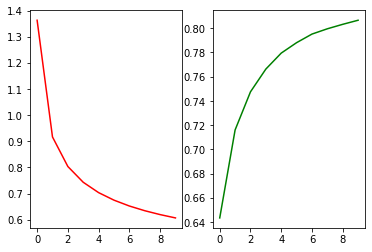

In [12]:
# 训练模型
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data




def train(net,tran_iter,test_iter,loss,epochs,batch_size,params,lr,optimizer=None):
  train_loss_list=[]
  train_accu_list=[]
  for epoch in range(epochs):
    train_loss_sum,train_acc_sum = 0.0,0.0
    n=0
    for X,y in train_iter:
      y_hat = net(X)
      l = loss(y_hat,y).sum()
      acc = accuracy(y_hat,y)
      train_loss_sum+=l.item()
      train_acc_sum+=acc.item()
      n+=y.shape[0]
      if params[0].grad is not None:#第一次不需要清零，第二次开始要
        for param in params:
          param.grad.data.zero_()
      l.backward()
      sgd(params,lr,batch_size)
    train_loss_list.append(train_loss_sum/n)
    train_accu_list.append(train_acc_sum/n) 
    test_acc = evaluate_acc(test_iter,net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
      % (epoch + 1, train_loss_sum / n, train_acc_sum / n, test_acc))
  ax = plt.subplot(121)
  ax.plot(train_loss_list,color='r')
  ax = plt.subplot(122)
  ax.plot(train_accu_list,color='green')

train(net, train_iter, test_iter, cross_entropy, 10, batch_size, [W, b], 0.01)

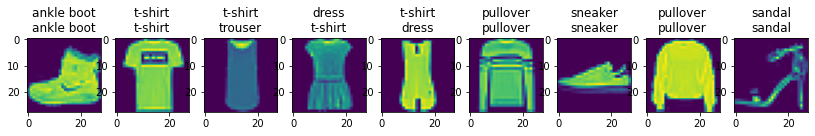

In [13]:
X, y = iter(test_iter).next()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], titles[0:9])